Aim: Work out an approach to clean data for license plate number segmentation. Observe various gradient in image and plot **Histogram of Oriented Gradient (HOG)** of the image. 

In [0]:
import imutils

In [0]:
# import libraries
import requests
import random
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import urllib
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [4]:
# Input data files are available in the "../input/" directory.
import os
os.listdir()

['.config', 'Indian_Number_plates.json', 'sample_data']

In [0]:
import json

# Read the data
data = pd.read_json('Indian_Number_plates.json', lines=True)
pd.set_option('display.max_colwidth', -1)

# Delete the empty column
del data['extras']

# Extract the points of the bounding boxes because thats what we want
data['points'] = data.apply(lambda row: row['annotation'][0]['points'], axis=1)

# And drop the rest of the annotation info
del data['annotation']

Images = []
Plates = []

def downloadTraining(df):

    for index, row in df.iterrows():

        # Get the image from the URL
        resp = urllib.request.urlopen(row[0])
        im = np.array(Image.open(resp))

        # We append the image to the training input array
        Images.append(im)  

        # Points of rectangle
        x_point_top = row[1][0]['x']*im.shape[1]
        y_point_top = row[1][0]['y']*im.shape[0]
        x_point_bot = row[1][1]['x']*im.shape[1]
        y_point_bot = row[1][1]['y']*im.shape[0]

        # Cut the plate from the image and use it as output
        carImage = Image.fromarray(im)
        plateImage = carImage.crop((x_point_top, y_point_top, x_point_bot, y_point_bot))
        Plates.append(np.array(plateImage))

In [0]:
downloadTraining(data)

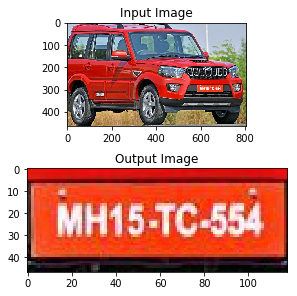

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axes
fig, ax = plt.subplots(2, 1, constrained_layout=True)

# Set title
ax[0].set_title('Input Image')
ax[1].set_title('Output Image')

# Display the images
ax[0].imshow(Images[0])
ax[1].imshow(Plates[0])

plt.show()

In [8]:
!pip install mahotas

     |████████████████████████████████| 1.5MB 9.7MB/s 
  Created wheel for mahotas: filename=mahotas-1.4.7-cp36-cp36m-linux_x86_64.whl size=4262313 sha256=ffde7164e4b4ddeed61f930fbd9efc37f4c38451f9e8194f463da7dfc26cd321
  Stored in directory: /root/.cache/pip/wheels/bb/0d/1e/c012eda7a9bb738a2fc531551681d680d31001abac3e14f3ed
Successfully built mahotas


In [0]:
import imutils
import mahotas

image = Plates[0]
# for image in Plates:
# Convert the coloured image into grayscale image
image_resized=imutils.resize(image, width=300)
image_gray=cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

# Do thresholding
image_thresh=image_gray
T=mahotas.thresholding.otsu(image_gray) # will find an optimal value of T from the image
image_thresh[image_thresh>T]=255 # This goes pixel by pixel if the pixel value of the thresh is greater than the optimal value then the color is white
image_thresh[image_thresh<T]=0   # This goes pixel by pixel if the pixel value of the thresh is greater than the optimal value then the color is Black
image_thresh = cv2.bitwise_not(image_thresh)


# Perform dialation
kernel = np.ones((1,1),np.uint8)
image_eroded = cv2.erode(image_thresh,kernel,iterations = 5)
image_eroded = cv2.morphologyEx(image_eroded, cv2.MORPH_OPEN, kernel, iterations = 1)
# image_eroded = cv2.erode(image_eroded,kernel,iterations = 1)


# We resize the numberplate Since we are using only cars we would resize it to 60*120 pixels
# image_resized= imutils.resize(image_eroded,width=90, height=30)


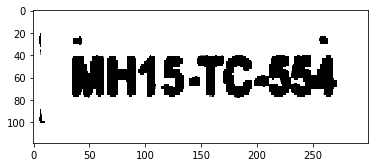

In [10]:
plt.imshow(image_eroded, cmap="gray")

In [11]:
image_eroded.shape

(119, 300)

In [12]:
image_eroded

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [0]:
'''
About: This code snippet is written to calculate the gradient of each pixel, every pixel of an image call this code snippet and the code snippet \
       returns the magnitude of the very pixel.
'''

import math
import cv2


# Not needed in our case because we take care of the pixel coordinate in generate_pixel function ,, anyway this checks if the pixel in process is in range of the pixel size
def check_pixel_range (image, r, c):    #c is the column and r is the row
    total_size_xaxis=image.shape[1]
    total_size_yaxis=image.shape[0]
    return c>0 and c<total_size_xaxis-1 and r>0 and r<total_size_yaxis-1



# Calculate the dy (the change in y axis) we need the vertical neighbours to calculate dy
def cal_dy (image, r, c, default_delta=1.0):

    if not check_pixel_range(image,r,c):
         return default_delta
    vertical_neighbor_intensity_change=image[r-1,c]- image[r+1,c]# we have taken (r-1,c) and (r+1,c) because in openCV an image point is read as (r,c) not (c,r)
    dy=vertical_neighbor_intensity_change

    if dy==0:
        return default_delta
    else:
        return float(dy)



# Calculate the dx (the change in x axis) we need the horizontal neighbors to calculate dx
def cal_dx (image, r, c, default_delta=1.0):

    if not check_pixel_range(image,r,c):
         return default_delta
    horizontal_neighbor_intensity_change=image[r,c-1]- image[r,c+1] # we have taken (r-1,c) and (r+1,c) because in openCV an image point is read as (r,c) not (c,r)
    dx=horizontal_neighbor_intensity_change

    if dx==0:
        return default_delta
    else:
        return float(dx)


# Calculate the magnitude of the gradient
def cal_gradient_magnitude(dx, dy):
    magnitude=math.sqrt(math.pow(dx,2) + math.pow(dy,2))
    return magnitude


def call_magnitude(image, r,c):
    dy=cal_dy(image, r,c)
    dx=cal_dx(image,r,c)
    magnitude=int(cal_gradient_magnitude(dx,dy))

    return magnitude

In [0]:
from skimage.feature import hog
from skimage import exposure

image = image_eroded

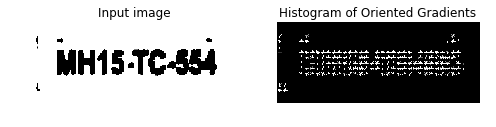

In [15]:
 '''
    About: The below code is the HOG class that instantiates HOG. HOG is used to create the features that is sent into a logistic regression machine or SVM Machine.
    With the use of HOG feature we develop a model or find the optimal theta value which is again used for a new instance to predict the output if the image is a number plate or not number plate
'''

def describe(image):
      hist , hog_image= hog(image,
                          orientations = 9,
                          pixels_per_cell = (8, 8),
                          cells_per_block = (3, 3),
                          visualize= True,
                          multichannel=None)  
      return hist, hog_image
    
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
hist, hog_image = describe(image)
ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

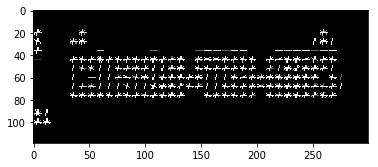

In [16]:
plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
plt.show()

**END OF NOTEBOOK**